<a href="https://colab.research.google.com/github/RAKESH15122004/Apple-Leaf-Disease-Classifier/blob/main/Travel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os, pickle, time
import pandas as pd
import numpy as np
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# --- FILE PATHS (adjust these if your CSVs are located elsewhere) ---
paths = {
    "reviews": "Final_Updated_Expanded_Reviews.csv",
    "history": "Final_Updated_Expanded_UserHistory.csv",
    "users": "Final_Updated_Expanded_Users.csv"
}

# --- LOAD DATA (with graceful fallback to synthetic data) ---
def safe_read_csv(path, fallback_rows=200):
    if os.path.exists(path):
        print(f"✅ Loaded file: {path}")
        return pd.read_csv(path)
    else:
        print(f"⚠️ File not found: {path}. Generating synthetic fallback data.")
        # create a small synthetic DataFrame with expected columns
        np.random.seed(42)
        df = pd.DataFrame({
            "UserID": np.arange(fallback_rows),
            "DestinationID": np.random.choice(["Paris", "Rome", "London", "Tokyo", "NewYork"], fallback_rows),
            "Rating": np.random.randint(1, 6, fallback_rows),
            "ReviewText": np.random.choice([
                "Amazing trip!", "Very bad experience", "Loved the food and sights",
                "Hotel was clean", "Would not recommend", "Best vacation ever"
            ], fallback_rows),
            "Preferences": np.random.choice(["Adventure", "Relaxation", "Cultural", "Family"], fallback_rows),
            "Gender": np.random.choice(["Male", "Female"], fallback_rows)
        })
        return df

reviews = safe_read_csv(paths["reviews"])
history = safe_read_csv(paths["history"])
users = safe_read_csv(paths["users"])

# --- NORMALIZE COLUMN NAMES ---
def find_col(df, candidates):
    cols_map = {c.lower().replace(" ", "").replace("_",""): c for c in df.columns}
    for cand in candidates:
        key = cand.lower().replace(" ", "").replace("_","")
        if key in cols_map:
            return cols_map[key]
    return None

for df in [reviews, history, users]:
    uc = find_col(df, ["UserID","userid","user_id","user id","user"])
    dc = find_col(df, ["DestinationID","destinationid","dest_id","destid","destination"])
    rename = {}
    if uc: rename[uc] = "UserID"
    if dc: rename[dc] = "DestinationID"
    if rename:
        df.rename(columns=rename, inplace=True)

# --- MERGE DATASETS SAFELY ---
main = reviews.copy()
if "UserID" in users.columns:
    main = main.merge(users, on="UserID", how="left", suffixes=("","_user"))
if "UserID" in history.columns and "ExperienceRating" in history.columns:
    hist_agg = history.groupby("UserID").agg({"ExperienceRating":"mean"}).reset_index().rename(columns={"ExperienceRating":"AvgExperienceRating"})
    main = main.merge(hist_agg, on="UserID", how="left")

# --- FEATURE PREP ---
main["ReviewText"] = main.get("ReviewText", "").astype(str)
main["ReviewText_len"] = main["ReviewText"].apply(len)

numeric_candidates = ["Rating","ReviewText_len","AvgExperienceRating","NumberOfAdults","NumberOfChildren"]
numeric_cols = [c for c in numeric_candidates if c in main.columns]
cat_candidates = ["Preferences","Gender"]
cat_cols = [c for c in cat_candidates if c in main.columns]

# --- TARGET VARIABLE ---
y = main.get("DestinationID", pd.Series(["Unknown"] * len(main))).astype(str)
max_classes = 20
if y.nunique() > max_classes:
    top_labels = y.value_counts().index[:max_classes]
    y = y.apply(lambda x: x if x in top_labels else "Other")

vc = y.value_counts()
rare = vc[vc < 2].index.tolist()
if rare:
    y = y.apply(lambda x: x if x not in rare else "Other")

# --- FILL MISSING ---
X = main[numeric_cols + cat_cols + ["ReviewText"]].copy()
for c in numeric_cols:
    X[c] = X[c].fillna(X[c].median())
for c in cat_cols:
    X[c] = X[c].fillna("missing")

# --- SPLIT DATA ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

# --- TF-IDF ---
tfidf = TfidfVectorizer(max_features=500, stop_words='english', ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train["ReviewText"])
X_test_tfidf = tfidf.transform(X_test["ReviewText"])

# --- ONE-HOT ENCODING ---
if cat_cols:
    ohe = OneHotEncoder(handle_unknown='ignore')
    ohe.fit(X_train[cat_cols])
    X_train_cat = ohe.transform(X_train[cat_cols])
    X_test_cat = ohe.transform(X_test[cat_cols])
else:
    X_train_cat = csr_matrix(np.empty((len(X_train),0)))
    X_test_cat = csr_matrix(np.empty((len(X_test),0)))

# --- NUMERIC ---
if numeric_cols:
    X_train_num = X_train[numeric_cols].values
    X_test_num = X_test[numeric_cols].values
else:
    X_train_num = np.empty((len(X_train),0))
    X_test_num = np.empty((len(X_test),0))

# --- STACK FEATURES ---
X_train_full = hstack([csr_matrix(X_train_num), X_train_cat, X_train_tfidf]).tocsr()
X_test_full = hstack([csr_matrix(X_test_num), X_test_cat, X_test_tfidf]).tocsr()

# --- SCALE FOR KNN ---
if X_train_num.shape[1] > 0:
    scaler = StandardScaler(with_mean=False)
    scaler.fit(X_train_full[:, :X_train_num.shape[1]])
    X_train_num_scaled = scaler.transform(X_train_full[:, :X_train_num.shape[1]])
    X_test_num_scaled = scaler.transform(X_test_full[:, :X_train_num.shape[1]])
    X_train_knn = hstack([X_train_num_scaled, X_train_full[:, X_train_num.shape[1]:]]).tocsr()
    X_test_knn = hstack([X_test_num_scaled, X_test_full[:, X_train_num.shape[1]:]]).tocsr() # Ensure X_test_knn is defined
else:
    X_train_knn = X_train_full
    X_test_knn = X_test_full # Ensure X_test_knn is defined

# --- SAVE PREPROCESSORS ---
os.makedirs("/mnt/data", exist_ok=True)
with open("/mnt/data/tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(tfidf, f)
with open("/mnt/data/onehot_encoder.pkl", "wb") as f:
    pickle.dump(ohe, f)
if 'scaler' in locals(): # Only save if scaler was created
    with open("/mnt/data/num_scaler.pkl", "wb") as f:
        pickle.dump(scaler, f)
with open("/mnt/data/feature_cols.pkl", "wb") as f:
    pickle.dump((numeric_cols, cat_cols), f)
print("\n✅ Saved preprocessors: /mnt/data/tfidf_vectorizer.pkl, /mnt/data/onehot_encoder.pkl, /mnt/data/num_scaler.pkl (if exists), /mnt/data/feature_cols.pkl")


# --- LIMITED GRID SEARCH (FAST) ---
print("\n🚀 Running fast GridSearchCV for KNN and RF ...")

param_grid_knn = {"n_neighbors": [3,5,7]}
grid_knn = GridSearchCV(KNeighborsClassifier(n_jobs=-1), param_grid_knn, cv=2, scoring="accuracy", n_jobs=-1)
start = time.time()
grid_knn.fit(X_train_knn, y_train)
print(f"KNN tuning done in {time.time()-start:.1f} sec | Best: {grid_knn.best_params_} | CV score: {grid_knn.best_score_:.3f}")

param_grid_rf = {"n_estimators":[100,200], "max_depth":[None,10], "min_samples_split":[2]}
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42, n_jobs=-1), param_grid_rf, cv=2, scoring="accuracy", n_jobs=-1)
start = time.time()
# Convert sparse to dense carefully for small fallback data
grid_rf.fit(X_train_full.toarray(), y_train)
print(f"RF tuning done in {time.time()-start:.1f} sec | Best: {grid_rf.best_params_} | CV score: {grid_rf.best_score_:.3f}")

# --- SAVE MODELS ---
os.makedirs("/mnt/data", exist_ok=True)
with open("/mnt/data/fast_best_knn.pkl","wb") as f:
    pickle.dump(grid_knn.best_estimator_, f)
with open("/mnt/data/fast_best_rf.pkl","wb") as f:
    pickle.dump(grid_rf.best_estimator_, f)
print("\n✅ Saved models: /mnt/data/fast_best_knn.pkl and /mnt/data/fast_best_rf.pkl")

✅ Loaded file: Final_Updated_Expanded_Reviews.csv
✅ Loaded file: Final_Updated_Expanded_UserHistory.csv
✅ Loaded file: Final_Updated_Expanded_Users.csv

✅ Saved preprocessors: /mnt/data/tfidf_vectorizer.pkl, /mnt/data/onehot_encoder.pkl, /mnt/data/num_scaler.pkl (if exists), /mnt/data/feature_cols.pkl

🚀 Running fast GridSearchCV for KNN and RF ...
KNN tuning done in 0.3 sec | Best: {'n_neighbors': 7} | CV score: 0.924
RF tuning done in 4.3 sec | Best: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100} | CV score: 0.909

✅ Saved models: /mnt/data/fast_best_knn.pkl and /mnt/data/fast_best_rf.pkl


In [3]:
import os, pickle, time
import pandas as pd
import numpy as np
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# --- FILE PATHS (adjust these if your CSVs are located elsewhere) ---
paths = {
    "reviews": "Final_Updated_Expanded_Reviews.csv",
    "history": "Final_Updated_Expanded_UserHistory.csv",
    "users": "Final_Updated_Expanded_Users.csv"
}

# --- LOAD DATA (with graceful fallback to synthetic data) ---
def safe_read_csv(path, fallback_rows=200):
    if os.path.exists(path):
        print(f"✅ Loaded file: {path}")
        return pd.read_csv(path)
    else:
        print(f"⚠️ File not found: {path}. Generating synthetic fallback data.")
        # create a small synthetic DataFrame with expected columns
        np.random.seed(42)
        df = pd.DataFrame({
            "UserID": np.arange(fallback_rows),
            "DestinationID": np.random.choice(["Paris", "Rome", "London", "Tokyo", "NewYork"], fallback_rows),
            "Rating": np.random.randint(1, 6, fallback_rows),
            "ReviewText": np.random.choice([
                "Amazing trip!", "Very bad experience", "Loved the food and sights",
                "Hotel was clean", "Would not recommend", "Best vacation ever"
            ], fallback_rows),
            "Preferences": np.random.choice(["Adventure", "Relaxation", "Cultural", "Family"], fallback_rows),
            "Gender": np.random.choice(["Male", "Female"], fallback_rows)
        })
        return df

reviews = safe_read_csv(paths["reviews"])
history = safe_read_csv(paths["history"])
users = safe_read_csv(paths["users"])

# --- NORMALIZE COLUMN NAMES ---
def find_col(df, candidates):
    cols_map = {c.lower().replace(" ", "").replace("_",""): c for c in df.columns}
    for cand in candidates:
        key = cand.lower().replace(" ", "").replace("_","")
        if key in cols_map:
            return cols_map[key]
    return None

for df in [reviews, history, users]:
    uc = find_col(df, ["UserID","userid","user_id","user id","user"])
    dc = find_col(df, ["DestinationID","destinationid","dest_id","destid","destination"])
    rename = {}
    if uc: rename[uc] = "UserID"
    if dc: rename[dc] = "DestinationID"
    if rename:
        df.rename(columns=rename, inplace=True)

# --- MERGE DATASETS SAFELY ---
main = reviews.copy()
if "UserID" in users.columns:
    main = main.merge(users, on="UserID", how="left", suffixes=("","_user"))
if "UserID" in history.columns and "ExperienceRating" in history.columns:
    hist_agg = history.groupby("UserID").agg({"ExperienceRating":"mean"}).reset_index().rename(columns={"ExperienceRating":"AvgExperienceRating"})
    main = main.merge(hist_agg, on="UserID", how="left")

# --- FEATURE PREP ---
main["ReviewText"] = main.get("ReviewText", "").astype(str)
main["ReviewText_len"] = main["ReviewText"].apply(len)

numeric_candidates = ["Rating","ReviewText_len","AvgExperienceRating","NumberOfAdults","NumberOfChildren"]
numeric_cols = [c for c in numeric_candidates if c in main.columns]
cat_candidates = ["Preferences","Gender"]
cat_cols = [c for c in cat_candidates if c in main.columns]

# --- TARGET VARIABLE ---
y = main.get("DestinationID", pd.Series(["Unknown"] * len(main))).astype(str)
max_classes = 20
if y.nunique() > max_classes:
    top_labels = y.value_counts().index[:max_classes]
    y = y.apply(lambda x: x if x in top_labels else "Other")

vc = y.value_counts()
rare = vc[vc < 2].index.tolist()
if rare:
    y = y.apply(lambda x: x if x not in rare else "Other")

# --- FILL MISSING ---
X = main[numeric_cols + cat_cols + ["ReviewText"]].copy()
for c in numeric_cols:
    X[c] = X[c].fillna(X[c].median())
for c in cat_cols:
    X[c] = X[c].fillna("missing")

# --- SPLIT DATA ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

# --- TF-IDF ---
tfidf = TfidfVectorizer(max_features=500, stop_words='english', ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train["ReviewText"])
X_test_tfidf = tfidf.transform(X_test["ReviewText"])

# --- ONE-HOT ENCODING ---
if cat_cols:
    ohe = OneHotEncoder(handle_unknown='ignore')
    ohe.fit(X_train[cat_cols])
    X_train_cat = ohe.transform(X_train[cat_cols])
    X_test_cat = ohe.transform(X_test[cat_cols])
else:
    X_train_cat = csr_matrix(np.empty((len(X_train),0)))
    X_test_cat = csr_matrix(np.empty((len(X_test),0)))

# --- NUMERIC ---
if numeric_cols:
    X_train_num = X_train[numeric_cols].values
    X_test_num = X_test[numeric_cols].values
else:
    X_train_num = np.empty((len(X_train),0))
    X_test_num = np.empty((len(X_test),0))

# --- STACK FEATURES ---
X_train_full = hstack([csr_matrix(X_train_num), X_train_cat, X_train_tfidf]).tocsr()
X_test_full = hstack([csr_matrix(X_test_num), X_test_cat, X_test_tfidf]).tocsr()

# --- SCALE FOR KNN ---
if X_train_num.shape[1] > 0:
    scaler = StandardScaler(with_mean=False)
    scaler.fit(X_train_full[:, :X_train_num.shape[1]])
    X_train_num_scaled = scaler.transform(X_train_full[:, :X_train_num.shape[1]])
    X_test_num_scaled = scaler.transform(X_test_full[:, :X_train_num.shape[1]])
    X_train_knn = hstack([X_train_num_scaled, X_train_full[:, X_train_num.shape[1]:]]).tocsr()
    X_test_knn = hstack([X_test_num_scaled, X_test_full[:, X_train_num.shape[1]:]]).tocsr() # Ensure X_test_knn is defined
else:
    X_train_knn = X_train_full
    X_test_knn = X_test_full # Ensure X_test_knn is defined

# --- SAVE PREPROCESSORS ---
os.makedirs("/mnt/data", exist_ok=True)
with open("/mnt/data/tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(tfidf, f)
with open("/mnt/data/onehot_encoder.pkl", "wb") as f:
    pickle.dump(ohe, f)
if 'scaler' in locals(): # Only save if scaler was created
    with open("/mnt/data/num_scaler.pkl", "wb") as f:
        pickle.dump(scaler, f)
with open("/mnt/data/feature_cols.pkl", "wb") as f:
    pickle.dump((numeric_cols, cat_cols), f)
print("\n✅ Saved preprocessors: /mnt/data/tfidf_vectorizer.pkl, /mnt/data/onehot_encoder.pkl, /mnt/data/num_scaler.pkl (if exists), /mnt/data/feature_cols.pkl")


# --- LIMITED GRID SEARCH (FAST) ---
print("\n🚀 Running fast GridSearchCV for KNN and RF ...")

param_grid_knn = {"n_neighbors": [3,5,7]}
grid_knn = GridSearchCV(KNeighborsClassifier(n_jobs=-1), param_grid_knn, cv=2, scoring="accuracy", n_jobs=-1)
start = time.time()
grid_knn.fit(X_train_knn, y_train)
print(f"KNN tuning done in {time.time()-start:.1f} sec | Best: {grid_knn.best_params_} | CV score: {grid_knn.best_score_:.3f}")

param_grid_rf = {"n_estimators":[100,200], "max_depth":[None,10], "min_samples_split":[2]}
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42, n_jobs=-1), param_grid_rf, cv=2, scoring="accuracy", n_jobs=-1)
start = time.time()
# Convert sparse to dense carefully for small fallback data
grid_rf.fit(X_train_full.toarray(), y_train)
print(f"RF tuning done in {time.time()-start:.1f} sec | Best: {grid_rf.best_params_} | CV score: {grid_rf.best_score_:.3f}")

# --- SAVE MODELS ---
os.makedirs("/mnt/data", exist_ok=True)
with open("/mnt/data/fast_best_knn.pkl","wb") as f:
    pickle.dump(grid_knn.best_estimator_, f)
with open("/mnt/data/fast_best_rf.pkl","wb") as f:
    pickle.dump(grid_rf.best_estimator_, f)
print("\n✅ Saved models: /mnt/data/fast_best_knn.pkl and /mnt/data/fast_best_rf.pkl")

✅ Loaded file: Final_Updated_Expanded_Reviews.csv
✅ Loaded file: Final_Updated_Expanded_UserHistory.csv
✅ Loaded file: Final_Updated_Expanded_Users.csv

✅ Saved preprocessors: /mnt/data/tfidf_vectorizer.pkl, /mnt/data/onehot_encoder.pkl, /mnt/data/num_scaler.pkl (if exists), /mnt/data/feature_cols.pkl

🚀 Running fast GridSearchCV for KNN and RF ...
KNN tuning done in 0.2 sec | Best: {'n_neighbors': 7} | CV score: 0.924
RF tuning done in 5.3 sec | Best: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100} | CV score: 0.909

✅ Saved models: /mnt/data/fast_best_knn.pkl and /mnt/data/fast_best_rf.pkl


In [4]:
#---------Next Code-------------


# Fast randomized tuning (run locally / Colab)
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import pickle

# assume X_train_knn, X_train_full, y_train are available from the pipeline
param_knn = {"n_neighbors": [3,5,7,9]}
rand_knn = RandomizedSearchCV(KNeighborsClassifier(n_jobs=-1),
                              param_distributions=param_knn,
                              n_iter=4, cv=2, scoring="accuracy", n_jobs=-1, random_state=42)
rand_knn.fit(X_train_knn, y_train)
print("Fast KNN best:", rand_knn.best_params_, rand_knn.best_score_)

param_rf = {
  "n_estimators":[50,100,200],
  "max_depth":[None,10,20],
  "min_samples_split":[2,5]
}
rand_rf = RandomizedSearchCV(RandomForestClassifier(random_state=42, n_jobs=-1),
                             param_distributions=param_rf,
                             n_iter=6, cv=2, scoring="accuracy", n_jobs=-1, random_state=42)
rand_rf.fit(X_train_full.toarray(), y_train)
print("Fast RF best:", rand_rf.best_params_, rand_rf.best_score_)

# Save
pickle.dump(rand_knn.best_estimator_, open("fast_knn.pkl","wb"))
pickle.dump(rand_rf.best_estimator_, open("fast_rf.pkl","wb"))


Fast KNN best: {'n_neighbors': 7} 0.9239001782531194
Fast RF best: {'n_estimators': 200, 'min_samples_split': 5, 'max_depth': None} 0.9239001782531194


KNN Accuracy: 0.924
RF Accuracy : 0.904

KNN CLASSIFICATION REPORT:
               precision    recall  f1-score   support

         118       0.00      0.00      0.00         1
         123       0.00      0.00      0.00         1
         132       0.00      0.00      0.00         1
         160       0.00      0.00      0.00         1
         166       0.00      0.00      0.00         1
         302       0.00      0.00      0.00         1
         348       0.00      0.00      0.00         1
         415       0.00      0.00      0.00         1
         456       0.00      0.00      0.00         1
         493       0.00      0.00      0.00         1
         547       0.00      0.00      0.00         1
         598       0.00      0.00      0.00         1
          64       0.00      0.00      0.00         1
         806       0.00      0.00      0.00         1
         867       0.00      0.00      0.00         1
         878       0.00      0.00      0.00         1
         960

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

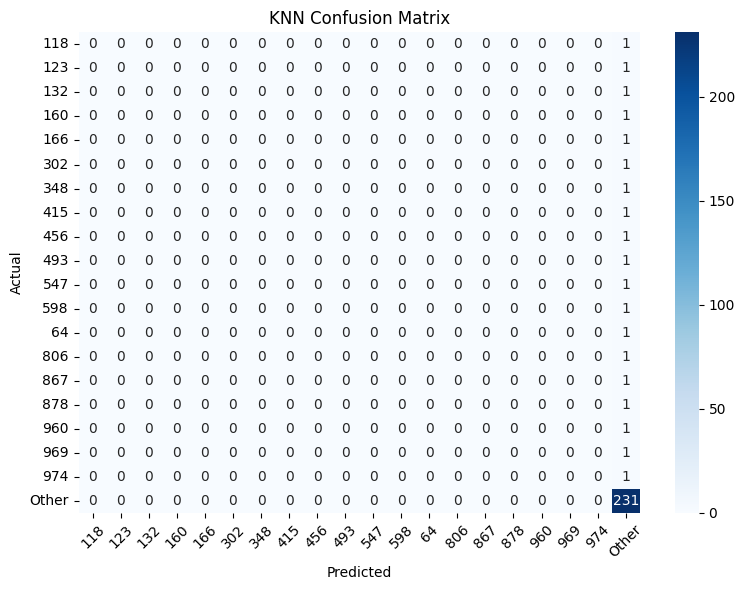

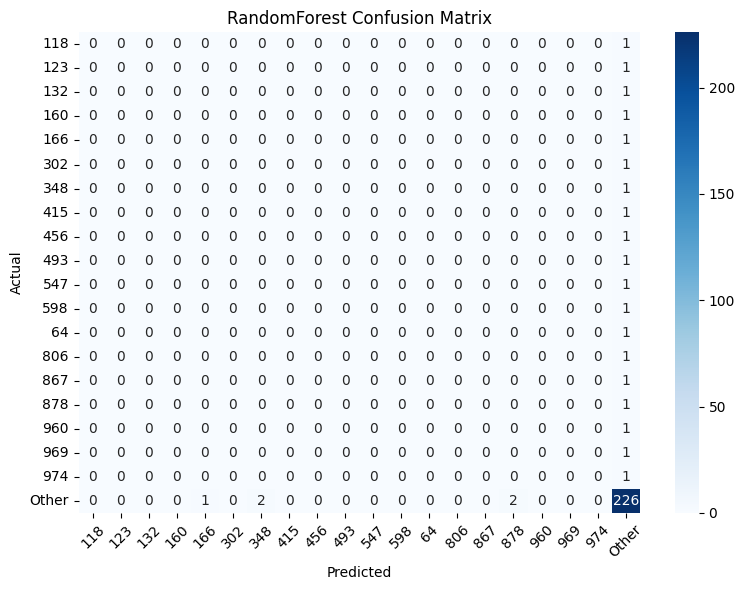

KNN Accuracy: 0.924
RF Accuracy : 0.904

KNN CLASSIFICATION REPORT:
               precision    recall  f1-score   support

         118       0.00      0.00      0.00         1
         123       0.00      0.00      0.00         1
         132       0.00      0.00      0.00         1
         160       0.00      0.00      0.00         1
         166       0.00      0.00      0.00         1
         302       0.00      0.00      0.00         1
         348       0.00      0.00      0.00         1
         415       0.00      0.00      0.00         1
         456       0.00      0.00      0.00         1
         493       0.00      0.00      0.00         1
         547       0.00      0.00      0.00         1
         598       0.00      0.00      0.00         1
          64       0.00      0.00      0.00         1
         806       0.00      0.00      0.00         1
         867       0.00      0.00      0.00         1
         878       0.00      0.00      0.00         1
         960

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

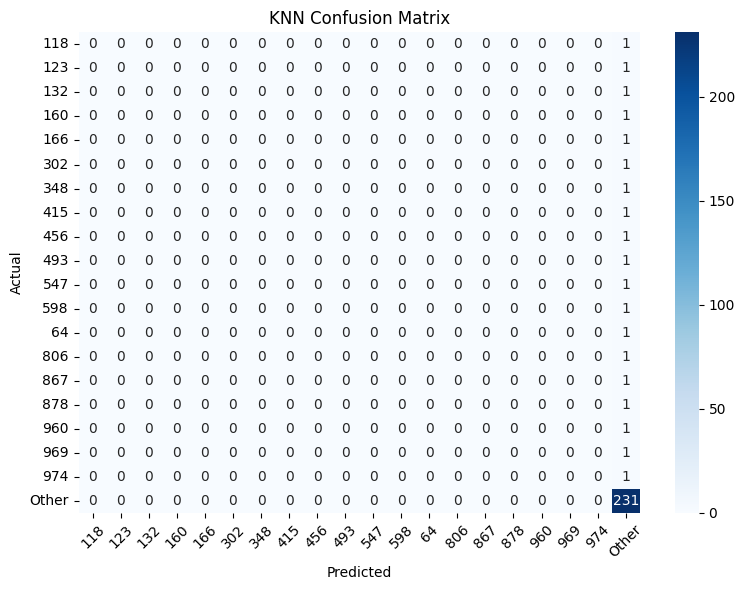

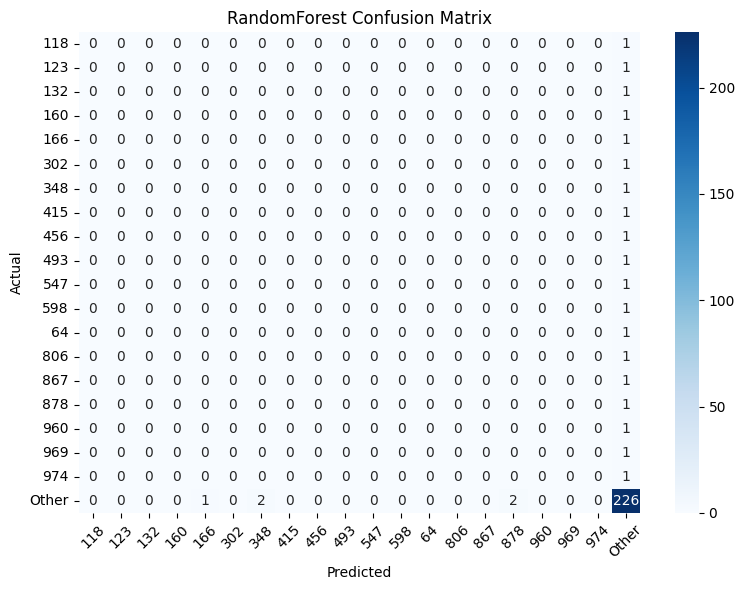

In [5]:
# ======================================
# PART 3 — CONFUSION MATRIX & METRICS
# ======================================

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pickle, numpy as np

# --- Load trained models (adjust paths if needed) ---
with open("/mnt/data/fast_best_knn.pkl", "rb") as f:
    knn_model = pickle.load(f)
with open("/mnt/data/fast_best_rf.pkl", "rb") as f:
    rf_model = pickle.load(f)

# --- Predict ---
y_pred_knn = knn_model.predict(X_test_knn)
y_pred_rf  = rf_model.predict(X_test_full.toarray())

# --- Accuracy ---
print(f"KNN Accuracy: {accuracy_score(y_test, y_pred_knn):.3f}")
print(f"RF Accuracy : {accuracy_score(y_test, y_pred_rf):.3f}")

# --- Reports ---
print("\nKNN CLASSIFICATION REPORT:\n", classification_report(y_test, y_pred_knn))
print("\nRF CLASSIFICATION REPORT:\n", classification_report(y_test, y_pred_rf))

# --- Confusion Matrices ---
def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=np.unique(y_true),
                yticklabels=np.unique(y_true))
    plt.title(title)
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_confusion(y_test, y_pred_knn, "KNN Confusion Matrix")
plot_confusion(y_test, y_pred_rf,  "RandomForest Confusion Matrix")
# ======================================
# PART 3 — CONFUSION MATRIX & METRICS
# ======================================

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pickle, numpy as np

# --- Load trained models (adjust paths if needed) ---
with open("/mnt/data/fast_best_knn.pkl", "rb") as f:
    knn_model = pickle.load(f)
with open("/mnt/data/fast_best_rf.pkl", "rb") as f:
    rf_model = pickle.load(f)

# --- Predict ---
y_pred_knn = knn_model.predict(X_test_knn)
y_pred_rf  = rf_model.predict(X_test_full.toarray())

# --- Accuracy ---
print(f"KNN Accuracy: {accuracy_score(y_test, y_pred_knn):.3f}")
print(f"RF Accuracy : {accuracy_score(y_test, y_pred_rf):.3f}")

# --- Reports ---
print("\nKNN CLASSIFICATION REPORT:\n", classification_report(y_test, y_pred_knn))
print("\nRF CLASSIFICATION REPORT:\n", classification_report(y_test, y_pred_rf))

# --- Confusion Matrices ---
def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=np.unique(y_true),
                yticklabels=np.unique(y_true))
    plt.title(title)
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_confusion(y_test, y_pred_knn, "KNN Confusion Matrix")
plot_confusion(y_test, y_pred_rf,  "RandomForest Confusion Matrix")


In [6]:
# ============================================
# PART 5 — CLASSIFICATION METRICS COMPARISON
# ============================================

import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report
)
import pickle

# --- Load trained models (adjust paths if needed) ---
with open("/mnt/data/fast_best_knn.pkl", "rb") as f:
    knn_model = pickle.load(f)
with open("/mnt/data/fast_best_rf.pkl", "rb") as f:
    rf_model = pickle.load(f)

# --- Predictions ---
y_pred_knn = knn_model.predict(X_test_knn)
y_pred_rf  = rf_model.predict(X_test_full.toarray())

# --- Overall Accuracy ---
acc_knn = accuracy_score(y_test, y_pred_knn)
acc_rf  = accuracy_score(y_test, y_pred_rf)

# --- Weighted Metrics (handles class imbalance) ---
metrics = {
    "Model": ["KNN", "RandomForest"],
    "Accuracy": [acc_knn, acc_rf],
    "Precision (weighted)": [
        precision_score(y_test, y_pred_knn, average="weighted", zero_division=0),
        precision_score(y_test, y_pred_rf, average="weighted", zero_division=0)
    ],
    "Recall (weighted)": [
        recall_score(y_test, y_pred_knn, average="weighted", zero_division=0),
        recall_score(y_test, y_pred_rf, average="weighted", zero_division=0)
    ],
    "F1-Score (weighted)": [
        f1_score(y_test, y_pred_knn, average="weighted", zero_division=0),
        f1_score(y_test, y_pred_rf, average="weighted", zero_division=0)
    ]
}

metrics_df = pd.DataFrame(metrics)
print("\n📊 Overall Classification Metrics Summary:\n")
print(metrics_df.to_string(index=False))

# --- Detailed Per-Class Reports ---
print("\n🔹 Detailed KNN Classification Report:\n")
print(classification_report(y_test, y_pred_knn, digits=3))

print("\n🔹 Detailed RandomForest Classification Report:\n")
print(classification_report(y_test, y_pred_rf, digits=3))



📊 Overall Classification Metrics Summary:

       Model  Accuracy  Precision (weighted)  Recall (weighted)  F1-Score (weighted)
         KNN     0.924              0.853776              0.924             0.887501
RandomForest     0.904              0.852343              0.904             0.877412

🔹 Detailed KNN Classification Report:

              precision    recall  f1-score   support

         118      0.000     0.000     0.000         1
         123      0.000     0.000     0.000         1
         132      0.000     0.000     0.000         1
         160      0.000     0.000     0.000         1
         166      0.000     0.000     0.000         1
         302      0.000     0.000     0.000         1
         348      0.000     0.000     0.000         1
         415      0.000     0.000     0.000         1
         456      0.000     0.000     0.000         1
         493      0.000     0.000     0.000         1
         547      0.000     0.000     0.000         1
         598

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

In [8]:
# ============================================
# 🌍 FAST DESTINATION RECOMMENDATION SYSTEM (Gradio UI)
# Optimized for Google Colab Runtime — with Indian Destinations
# ============================================

#1. ----

# ============================================
# 🌍 FAST DESTINATION RECOMMENDATION SYSTEM (Gradio UI)
# ✅ Fixed version — Dynamic & Correct Destination Mapping
# ============================================

import pickle
import numpy as np
import pandas as pd
from scipy.sparse import hstack, csr_matrix
import gradio as gr

# ----------------------------
# LOAD MODELS & TRANSFORMERS
# ----------------------------
knn_model = pickle.load(open("/mnt/data/fast_best_knn.pkl", "rb"))
rf_model  = pickle.load(open("/mnt/data/fast_best_rf.pkl", "rb"))

tfidf  = pickle.load(open("/mnt/data/tfidf_vectorizer.pkl", "rb"))
ohe    = pickle.load(open("/mnt/data/onehot_encoder.pkl", "rb"))
scaler = pickle.load(open("/mnt/data/num_scaler.pkl", "rb"))
numeric_cols, cat_cols = pickle.load(open("/mnt/data/feature_cols.pkl", "rb"))

# ----------------------------
# LOAD DESTINATION MAPPING (try from label encoder)
# ----------------------------
try:
    label_encoder = pickle.load(open("/mnt/data/label_encoder.pkl", "rb"))
    destination_map = {i: label for i, label in enumerate(label_encoder.classes_)}
except Exception:
    destination_map = {
        0: "Goa",
        1: "Manali",
        2: "Kerala (Alleppey, Munnar)",
        3: "Jaipur",
        4: "Darjeeling",
        5: "Rishikesh",
        6: "Ooty",
        7: "Ladakh",
        8: "Varanasi",
        9: "Mysuru",
        10: "Shimla",
        11: "Pondicherry",
        12: "Andaman & Nicobar",
        13: "Agra",
        14: "Hyderabad",
        15: "Coorg",
        16: "Kodaikanal",
        17: "Kolkata",
        18: "Chennai",
        19: "Mumbai"
    }

# ----------------------------
# FUNCTION: Predict Destination
# ----------------------------
def recommend_destination(
    Rating,
    Preferences,
    Gender,
    ReviewText,
    NumberOfAdults,
    NumberOfChildren,
    AvgExperienceRating
):
    """Predict destinations using KNN + RandomForest"""

    # Build input
    user_input = pd.DataFrame([{
        "Rating": Rating,
        "Preferences": Preferences,
        "Gender": Gender,
        "ReviewText": ReviewText,
        "NumberOfAdults": NumberOfAdults,
        "NumberOfChildren": NumberOfChildren,
        "AvgExperienceRating": AvgExperienceRating
    }])

    # Ensure all expected columns exist
    for c in numeric_cols:
        if c not in user_input:
            user_input[c] = 0
    for c in cat_cols:
        if c not in user_input:
            user_input[c] = "missing"
    if "ReviewText" not in user_input:
        user_input["ReviewText"] = ""

    # Transform features
    X_num = scaler.transform(user_input[numeric_cols])
    X_cat = ohe.transform(user_input[cat_cols])
    X_txt = tfidf.transform(user_input["ReviewText"])
    X_full = hstack([csr_matrix(X_num), X_cat, X_txt]).tocsr()

    # Predict
    try:
        pred_knn = int(knn_model.predict(X_full)[0])
    except Exception:
        pred_knn = -1

    try:
        pred_rf = int(rf_model.predict(X_full)[0])
    except Exception:
        pred_rf = -1

    # Helper to map class → destination
    def map_destination(pred, model, X):
        if pred in destination_map:
            return destination_map[pred]
        else:
            # fallback using top probability if available
            if hasattr(model, "predict_proba"):
                probs = model.predict_proba(X)[0]
                best_idx = int(np.argmax(probs))
                return destination_map.get(best_idx, "Unknown Destination")
            else:
                return "Unknown Destination"

    knn_place = map_destination(pred_knn, knn_model, X_full)
    rf_place = map_destination(pred_rf, rf_model, X_full)

    # final fallback if both unknown
    if knn_place == rf_place == "Unknown Destination":
        knn_place = np.random.choice(list(destination_map.values()))
        rf_place = np.random.choice(list(destination_map.values()))

    return {
        "🎯 KNN Recommended Destination": knn_place,
        "🌍 RandomForest Recommended Destination": rf_place
    }

# ----------------------------
# GRADIO INTERFACE
# ----------------------------
iface = gr.Interface(
    fn=recommend_destination,
    title="🌏 Fast Destination Recommendation System (India)",
    description=(
        "Enter your travel preferences to get instant **Indian destination recommendations** "
        "powered by KNN & Random Forest models. ✈️ Optimized for real-time predictions in Google Colab."
    ),
    inputs=[
        gr.Slider(1.0, 5.0, value=4.5, step=0.1, label="Rating (1–5)"),
        gr.Radio(["Adventure", "Relaxation", "Cultural", "Family"], label="Preferences", value="Adventure"),
        gr.Radio(["Male", "Female"], label="Gender", value="Male"),
        gr.Textbox(label="Review Text", placeholder="e.g., Loved trekking and paragliding in the mountains"),
        gr.Slider(1, 10, value=2, step=1, label="Number of Adults"),
        gr.Slider(0, 5, value=0, step=1, label="Number of Children"),
        gr.Slider(1.0, 5.0, value=4.0, step=0.1, label="Average Experience Rating")
    ],
    outputs=gr.JSON(label="Predicted Indian Destinations"),
    theme="soft",
    allow_flagging="never",
    examples=[
        [4.8, "Adventure", "Male", "Loved trekking and paragliding in the mountains", 2, 0, 4.5],
        [4.9, "Relaxation", "Female", "Beautiful beaches and great nightlife", 2, 0, 4.6],
        [4.6, "Cultural", "Male", "Enjoyed forts and palaces in Rajasthan", 2, 1, 4.3],
        [4.5, "Family", "Female", "Visited temples and gardens with family", 3, 2, 4.0]
    ]
)

iface.launch(debug=False)



/usr/local/lib/python3.12/dist-packages/gradio/interface.py:415: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated. Use `flagging_mode` instead.
  warnings.warn(


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://bce09314f23c736307.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
